In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

from scipy.ndimage import gaussian_filter1d

#from itertools import product
from pynwb import NWBHDF5IO
from nlb_tools.nwb_interface import NWBDataset

import warnings
warnings.filterwarnings("ignore")

In [5]:
# 'dandi download' downloads the data in this folder:
datapath = '/home/makki/data/NLB/000128/sub-Jenkins/sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb'
dataset = NWBDataset(datapath)

# Extract neural data and lagged hand velocity.
binsize = 1 #ms
dataset.resample(binsize)

trial_info = dataset.trial_info

# Combining the number of columns in the 'spikes' field with those in the 'heldout_spikes' field gives the total number of neurons.

n_null_trials = trial_info.isnull().sum()['success']
n_neurons = dataset.data.spikes.values.shape[1] + dataset.data.heldout_spikes.values.shape[1]

print(f'number of neurons: {n_neurons}')
print(f'total number of trials: {len(trial_info)}')
print(f'number of null trials: {n_null_trials}')

Dataset already at 1 ms resolution, skipping resampling...


number of neurons: 182
total number of trials: 2295
number of null trials: 0


In [6]:
trial_info

,trial_id,start_time,end_time,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,move_onset_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target,split
0,0,0 days 00:00:00,0 days 00:00:03.321000,25,2,84,True,0 days 00:00:00.880000,0 days 00:00:01.478000,0 days 00:00:01.905000,427,598,3,"[[-111, -82], [-108, 81], [118, 72]]",8,"[[69, 31, 14, 99], [69, 54, 5, 101], [-62, -48...",2,val
1,1,0 days 00:00:03.400000,0 days 00:00:06.521000,3,1,3,True,0 days 00:00:04.291000,0 days 00:00:04.739000,0 days 00:00:05.280000,541,448,1,"[[-116, -5]]",6,"[[-69, -16, 13, 69], [-120, -62, 83, 15], [95,...",0,val
2,2,0 days 00:00:06.600000,0 days 00:00:09.856000,22,1,66,True,0 days 00:00:07.471000,0 days 00:00:07.969000,0 days 00:00:08.346000,377,498,1,"[[-82, -86]]",9,"[[34, -41, 86, 8], [9, -42, 33, 19], [7, -41, ...",0,train
3,3,0 days 00:00:09.900000,0 days 00:00:12.946000,29,2,100,True,0 days 00:00:10.853000,0 days 00:00:11.335000,0 days 00:00:11.752000,417,482,3,"[[-109, 2], [2, 82], [132, -65]]",9,"[[-9, 52, 43, 8], [-50, 91, 14, 64], [-133, -5...",1,train
4,4,0 days 00:00:13,0 days 00:00:15.481000,21,0,65,True,0 days 00:00:13.687000,0 days 00:00:14.235000,0 days 00:00:14.507000,272,548,1,"[[27, 82]]",0,[],0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,2290,0 days 01:55:36.600000,0 days 01:55:39.796000,34,1,91,True,0 days 01:55:37.362000,0 days 01:55:38.277000,0 days 01:55:38.585000,308,915,1,"[[116, -77]]",7,"[[66, -43, 30, 9], [-66, 1, 11, 70], [-35, 50,...",0,train
2291,2291,0 days 01:55:39.900000,0 days 01:55:42.736000,15,1,75,True,0 days 01:55:40.717000,0 days 01:55:41.265000,0 days 01:55:41.641000,376,548,1,"[[133, -81]]",9,"[[-33, 47, 37, 6], [-77, 48, 61, 11], [-64, -2...",0,train
2292,2292,0 days 01:55:42.800000,0 days 01:55:45.766000,23,0,67,True,0 days 01:55:43.465000,0 days 01:55:44.396000,0 days 01:55:44.714000,318,931,1,"[[94, -86]]",0,[],0,train
2293,2293,0 days 01:55:45.800000,0 days 01:55:49.201000,25,2,84,True,0 days 01:55:46.631000,0 days 01:55:46.663000,0 days 01:55:47.616000,953,32,3,"[[-111, -82], [-108, 81], [118, 72]]",8,"[[69, 31, 14, 99], [69, 54, 5, 101], [-62, -48...",2,val


In [7]:
# The make_trial_data() returns a DataFrame containing trialized data. It has the same fields as the continuous `dataset.data` DataFrame,
# But adds `trial_id`, `trial_time`, and `align_time`. Till here, each row is still a time bin.
# Note: Later we do the cropping and alignment arount move_onset by ourselves.

trial_data = dataset.make_trial_data()
len(trial_data)

KeyboardInterrupt: 

In [ ]:
trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(start, end))

### Forming trials

In [21]:
#[col for col in trial_data.columns if any(_ in col for _ in ['vel', 'pos', 'force', 'acc', 'target'])]
label_cols = [col for col in trial_data.columns if any(_ in col for _ in ['x', 'y'])]
label_cols

NameError: name 'trial_data' is not defined

In [289]:
obj = 'hand'
mes = 'vel'

KeyError: Timedelta('0 days 00:00:02.564999')

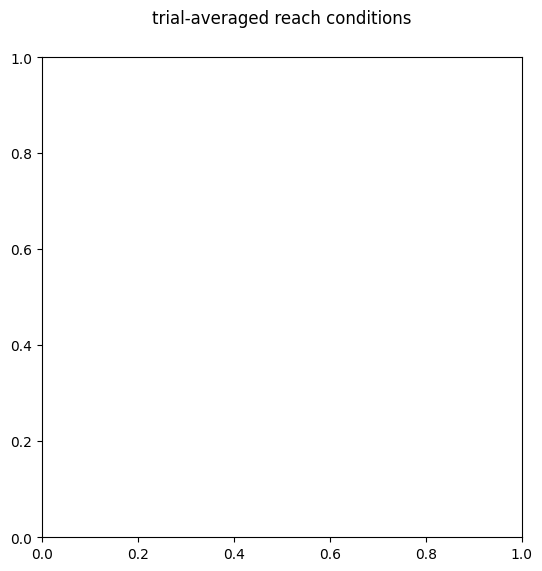

In [23]:
## Plot trial-averaged reaches

# Find unique conditions
maze_conds = trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
maze_conds = [cond for cond in maze_conds if not any(math.isnan(x) for x in cond)]

orig_conds = {}
#simp_conds = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

fig = plt.figure(figsize=(6, 6))
fig.suptitle('trial-averaged reach conditions')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond_idx, cond in enumerate(maze_conds):
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    trial_d = dataset.make_trial_data(align_field='move_onset_time', align_range=(-240, 660), ignored_trials=(~mask))
    traj = trial_d.groupby('align_time')[[(f'{obj}_{mes}', 'x'), (f'{obj}_{mes}', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    reach_angle = np.arctan2(*trial_info[mask].target_pos.iloc[0][int(trial_info[mask].active_target.iloc[0])][::-1])
    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
    
    orig_conds[cond_idx] = trial_d.trial_id.drop_duplicates().values
    #simp_conds[get_simple_cond(math.degrees(reach_angle) + 360 / 2)].append(trial_d.trial_id.drop_duplicates().values)
    
maze_conds = torch.tensor(maze_conds)
#simp_conds = {key: np.concatenate(value) for key, value in simp_conds.items()}
    
plt.axis('off')
plt.show()
'''
conds = []
for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    for cond, trial_ids in orig_conds.items():
        if trial_id in trial_ids:
            conds.append(cond)
            break
conds = torch.tensor(conds)
'''          
maze_conds = torch.tensor(maze_conds)

print(maze_conds.shape)
print(orig_conds.keys())

In [291]:
y = []
labels = []
target_pos = []
barrier_pos = []
active_targets = []
conds = []
true_targets = []

# We want total trial length of 900ms, which is 90 time bins.
bins_before = 48
bins_after = 132
n_bins = bins_before + bins_after

trial_length = bins_before + bins_after
n_trials = trial_data.shape[0] // trial_length

for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_info = trial_info[trial_info['trial_id'] == trial_id]
            
    # Get the untill movement in ms.
    move_time = (trial_id_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))
    # Get the number of bins until movement.
    move_bin = int(move_time // binsize)

    y_heldin_t = torch.tensor(trial.spikes.values)
    y_heldout_t = torch.tensor(trial.heldout_spikes.values)
    
    # Crop the trials arount the move_onset bin with offsets before and after that bin.
    y_t = torch.concat(
        [y_heldin_t[move_bin-bins_before:move_bin+bins_after, :], y_heldout_t[move_bin-bins_before:move_bin+bins_after, :]], dim=-1
    )
    
    y.append(y_t.reshape(1, trial_length, n_neurons))
    labels.append(torch.tensor(trial[f'{obj}_{mes}'].values[move_bin-bins_before:move_bin+bins_after, :]).reshape(1, trial_length, 2))
    
    target_pos.append(trial_id_info.target_pos.values[0])
    barrier_pos.append(trial_id_info.barrier_pos.values[0])
    active_targets.append(int(trial_id_info.active_target.values[0]))
    true_targets.append(trial_id_info.target_pos.values[0][int(trial_id_info.active_target.values[0])])
    
    for cond, trial_ids in orig_conds.items():
        if trial_id in trial_ids:
            conds.append(cond)
    
y = torch.concat(y, dim=0).float()
labels = torch.concat(labels, dim=0).float()
conds = torch.tensor(conds)
active_targets = torch.tensor(active_targets)
true_targets = torch.tensor(true_targets)

print(y.shape)
print(labels.shape)
print(conds.shape)
print(len(target_pos))
print(len(barrier_pos))
print(active_targets.shape)
print(true_targets.shape)

torch.Size([2294, 180, 182])
torch.Size([2294, 180, 2])
torch.Size([2294])
2294
2294
torch.Size([2294])
torch.Size([2294, 2])


### Dispersion analysis

In [293]:
conds_ids, cond_counts = torch.unique(conds, return_counts=True)
n_conds = len(conds_ids)
cond_counts

tensor([22, 24, 18, 25, 25, 23, 22, 27, 19, 26, 23, 24, 18, 17, 23, 18, 21, 24,
        20, 21, 20, 22, 18, 19, 25, 25, 20, 23, 24, 24, 21, 21, 22, 22, 19, 22,
        20, 20, 20, 18, 22, 21, 19, 22, 22, 22, 23, 22, 21, 21, 26, 19, 24, 22,
        20, 19, 20, 19, 24, 22, 22, 22, 20, 22, 21, 22, 18, 22, 23, 22, 20, 24,
        19, 19, 21, 21, 22, 18, 17, 22, 22, 22, 24, 18, 22, 21, 19, 19, 22, 22,
        21, 22, 21, 21, 19, 20, 20, 19, 22, 22, 23, 20, 20, 22, 22, 20, 19, 18])

In [294]:
unique_targets = [np.array(ut) for ut in set(tuple(ft) for ft in np.array(true_targets))]
len(unique_targets)

35

In [346]:
labels.shape

torch.Size([2294, 180, 2])

In [350]:
# Trial-averaged reaches of each condition
cxbxv = torch.zeros((n_conds, labels.shape[1], labels.shape[2]))
# The position of the active target that the animal is supposed to reach.
cxp = torch.zeros((n_conds, 2))
# Measure how disperse trials in each condition
c_std = torch.zeros((n_conds))

for ci in range(n_conds):
    mask = conds == ci
    
    cxbxv[ci, :, :] = labels[mask, :, :].mean(axis=0)
    c_std[ci] = cxbxv[ci, :, :].std(axis=0).mean(axis=0)
    # All trials in a condition have the same specified final active target
    cxp[ci, :] = torch.tensor(true_targets[mask][0])

print(cxbxv.shape)
print(c_std.shape)
print(cxp.shape)

torch.Size([108, 180, 2])
torch.Size([108])
torch.Size([108, 2])


In [296]:
cxd = torch.zeros((n_conds, cxbxv.shape[1], 2))
for ci in range(n_conds):
    means = torch.zeros((labels[conds == ci].shape[0]))
    for li, l in enumerate(labels[conds == ci]):
        means[li] = torch.norm(l - cxbxv[ci], dim=1).mean(dim=0)
        cxd[ci, :] = labels[conds == ci][torch.sort(means)[1][-1]]
print(cxd.shape)

lxd = torch.zeros((labels.shape[0], cxbxv.shape[1], 2))
ids = torch.zeros((labels.shape[0]))
means = torch.zeros((labels.shape[0]))
for li in range(labels.shape[0]):
    means[li] = torch.norm(labels[li] - labels[conds == conds[li]].mean(dim=0), dim=1).mean(dim=0)
lxd = labels[torch.sort(means)[1]]     
print(lxd.shape)

torch.Size([108, 180, 2])
torch.Size([2294, 180, 2])


In [297]:
lxd = torch.zeros((labels.shape[0], cxbxv.shape[1], 2))
ids = torch.zeros((labels.shape[0]))
means = torch.zeros((labels.shape[0]))
for li in range(labels.shape[0]):
    means[li] = torch.norm(labels[li] - labels[conds == conds[li]].mean(dim=0), dim=1).mean(dim=0)
lxd = labels[torch.sort(means)[1]]     
print(lxd.shape)

torch.Size([2294, 180, 2])


In [298]:
# Tensor of trials x bins x 2 where bins x 2 is the trial average reach condition for the condition of each trial
l_c_avg = torch.cat([a.unsqueeze(0) for a in [cxbxv[conds[li]] for li in range(labels.shape[0])]], dim=0)

In [299]:
# The point where the cursor stopped, for all trials
reach_targets = labels[:, -1, :]
# The avgerage point where the cursor stopped, for each conditions
cxv = cxbxv[:, -1, :]

In [300]:
# See how far each last reach of each trial from the true active target
t_r_norm = torch.norm(true_targets - reach_targets, dim=1)
t_r_norm

tensor([ 94.0849, 125.3966,  56.3349,  ..., 155.3423, 126.7588, 416.0012])

In [301]:
# See how far each last trial-averaged reach per condition from the true target in that condition 
c_r_norm = torch.norm(cxp - cxv, dim=1)

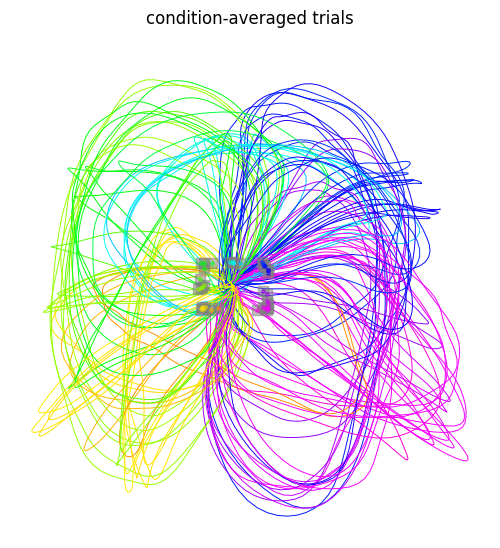

In [302]:
fig = plt.figure(figsize=(6, 6))
fig.suptitle(f'condition-averaged trials')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for cond_idx in conds_ids:
    traj = cxbxv[cond_idx, :, :]
    reach_angle = np.arctan2(cxp[cond_idx, 0], cxp[cond_idx, 1])
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5), zorder=1)
    ax.scatter(cxp[cond_idx, 0], cxp[cond_idx, 1], c='gray', alpha=0.2, marker='s', s=50, zorder=2)
    ax.scatter(cxp[cond_idx, 0], cxp[cond_idx, 1], c=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5), alpha=0.2, s=6.0, zorder=3)

# Maze frame (from the experiment)
#ax.set_xlim(-200+20, 200-20)
#ax.set_ylim(-155+20, 155-20)

#plt.text(125, 125, "x: true target", fontsize=8, ha='center', va='top')
#ax.text(0.5, -0.06, f"({n_conds} unique maze conditions, {len(unique_targets)} unique target locations)",  fontsize=10, ha='center', va='bottom', transform=plt.gca().transAxes)

plt.axis('off')
plt.show()

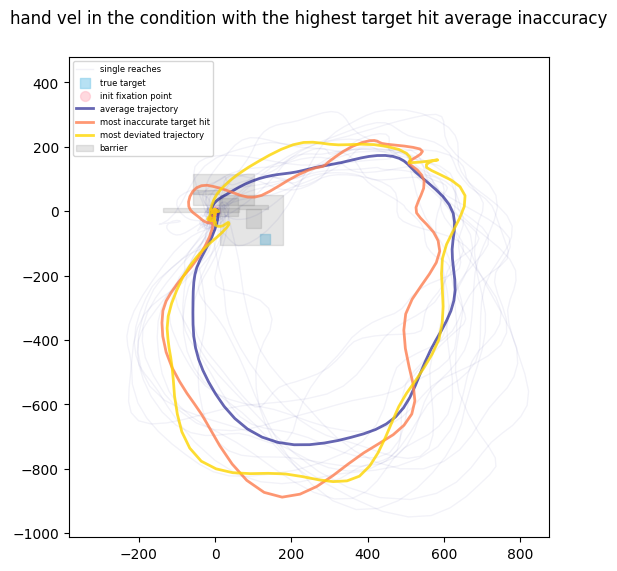

In [303]:
# The condition with the most inaccurate reaches:
inacc_c_id = torch.sort(c_r_norm)[1][-1]

# All reach trajectories in that condition:
trajectories = labels[conds == inacc_c_id]

avg_inacc_traj = trajectories.mean(dim=0)

# The most inaccurate trajectory in that condition:
inacc_traj = trajectories[torch.sort(t_r_norm[conds == inacc_c_id])[1][-1]]

# The most deviated trajectory
dev_traj = trajectories[torch.sort(
    torch.tensor([dis for dis in [torch.norm(trajectories[li] - avg_inacc_traj) for li in range(trajectories.shape[0])]]))[1][-1]]

# Targets shown in the maze for that condition:
#visible_targets =

# Initial fixation point:
init_fix = [0, 0]

# True target for taht condition:
true_target = true_targets[conds == inacc_c_id]

# They are all the same, lets just take one
barriers = [d for d, m in zip(barrier_pos, conds == torch.sort(c_r_norm)[1][-1]) if m]


fig = plt.figure(figsize=(6, 6))
fig.suptitle(f'{obj} {mes} in the condition with the highest target hit average inaccuracy', fontsize=12)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

cond_idx = inacc_c_id

for traj in trajectories:
    reach_angle = np.arctan2(traj[-1, 0], traj[-1, 1])
    ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
ax.scatter(cxp[cond_idx, 0], cxp[cond_idx, 1], color='skyblue', alpha=0.6, marker='s', s=50.0, zorder=1, label='true target')
ax.scatter(0, 0, c='pink', marker='o', alpha=0.6, s=50.0, zorder=1, label='init fixation point')
    
ax.plot(avg_inacc_traj[:, 0], avg_inacc_traj[:, 1], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')
ax.plot(inacc_traj[:, 0], inacc_traj[:, 1], linewidth=2.0, color='coral', alpha=0.8, zorder=4, label='most inaccurate target hit')
ax.plot(dev_traj[:, 0], dev_traj[:, 1], linewidth=2.0, color='gold', alpha=0.8, zorder=5, label='most deviated trajectory')

for bar in barriers[0]:
    x1, y1, x2, y2 = bar
    x3, y3 = x1, y2
    x4, y4 = x2, y1
    plt.fill([x1, x3, x2, x4, x1], [y1, y3, y2, y4, y1], c='gray', alpha=0.2, label='barrier' if (bar == barriers[0][0]).all() else '')
    
# Maze frame (from the experiment)
#ax.set_xlim(-200+20, 200-20)
#ax.set_ylim(-155+20, 155-20)
ax.set_xlim(plt.xlim()[0] - 100, plt.xlim()[1])
ax.set_ylim(plt.ylim()[0], plt.ylim()[1] + 100)

#plt.axis('off')
plt.legend(fontsize=6, loc='upper left')
fig.savefig(f'{obj}_{mes}_most_inaccurate_condition.pdf', bbox_inches='tight')
plt.show()

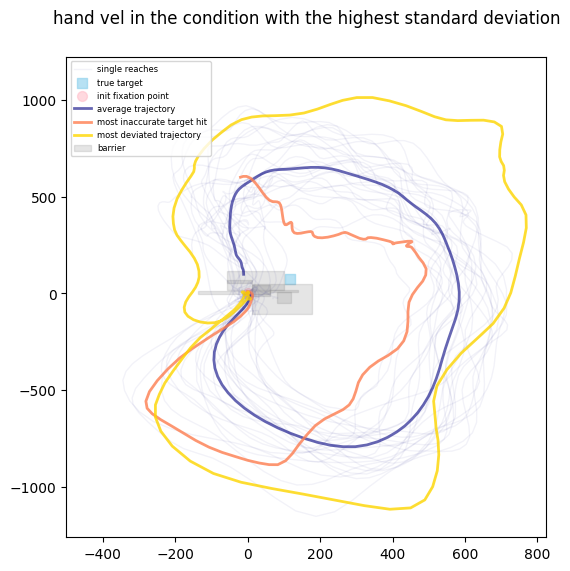

In [304]:
# The condition with the most inaccurate reaches:
inacc_c_id = torch.sort(c_std)[1][-1]

# All reach trajectories in that condition:
trajectories = labels[conds == inacc_c_id]

avg_inacc_traj = trajectories.mean(dim=0)

# The most inaccurate trajectory in that condition:
inacc_traj = trajectories[torch.sort(t_r_norm[conds == inacc_c_id])[1][-1]]

# The most deviated trajectory
dev_traj = trajectories[torch.sort(
    torch.tensor([dis for dis in [torch.norm(trajectories[li] - avg_inacc_traj) for li in range(trajectories.shape[0])]]))[1][-1]]

# Targets shown in the maze for that condition:
#visible_targets =

# Initial fixation point:
init_fix = [0, 0]

# True target for taht condition:
true_target = true_targets[conds == inacc_c_id]

# They are all the same, lets just take one
barriers = [d for d, m in zip(barrier_pos, conds == torch.sort(c_r_norm)[1][-1]) if m]


fig = plt.figure(figsize=(6, 6))
fig.suptitle(f'{obj} {mes} in the condition with the highest standard deviation', fontsize=12)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

cond_idx = inacc_c_id

for traj in trajectories:
    reach_angle = np.arctan2(traj[-1, 0], traj[-1, 1])
    ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
ax.scatter(cxp[cond_idx, 0], cxp[cond_idx, 1], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')
ax.scatter(0, 0, c='pink', marker='o', alpha=0.6, s=50.0, zorder=1, label='init fixation point')
    
ax.plot(avg_inacc_traj[:, 0], avg_inacc_traj[:, 1], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')
ax.plot(inacc_traj[:, 0], inacc_traj[:, 1], linewidth=2.0, color='coral', alpha=0.8, zorder=4, label='most inaccurate target hit')
ax.plot(dev_traj[:, 0], dev_traj[:, 1], linewidth=2.0, color='gold', alpha=0.8, zorder=5, label='most deviated trajectory')

for bar in barriers[0]:
    x1, y1, x2, y2 = bar
    x3, y3 = x1, y2
    x4, y4 = x2, y1
    plt.fill([x1, x3, x2, x4, x1], [y1, y3, y2, y4, y1], c='gray', alpha=0.2, label='barrier' if (bar == barriers[0][0]).all() else '')
    
# Maze frame (from the experiment)
#ax.set_xlim(-200+20, 200-20)
#ax.set_ylim(-155+20, 155-20)
ax.set_xlim(plt.xlim()[0] - 100, plt.xlim()[1])
ax.set_ylim(plt.ylim()[0], plt.ylim()[1] + 100)

#plt.axis('off')
plt.legend(fontsize=6, loc='upper left')
fig.savefig(f'{obj}_{mes}_most_dispersed_condition.pdf', bbox_inches='tight')
plt.show()

### How much the reach trajectories deviate in timing and speed in addition to the integrated position

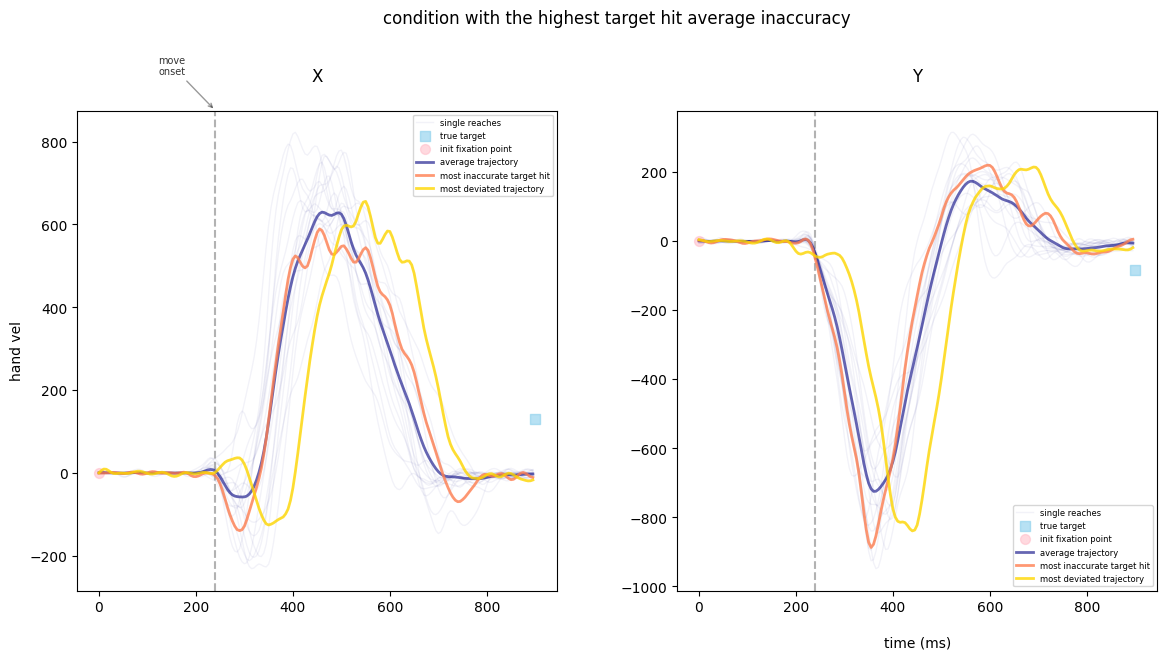

In [306]:
# The condition with the most inaccurate reaches:
inacc_c_id = torch.sort(c_r_norm)[1][-1]

# All reach trajectories in that condition:
trajectories = labels[conds == inacc_c_id]

avg_inacc_traj = trajectories.mean(dim=0)

# The most inaccurate trajectory in that condition:
inacc_traj = trajectories[torch.sort(t_r_norm[conds == inacc_c_id])[1][-1]]

# The most deviated trajectory
dev_traj = trajectories[torch.sort(
    torch.tensor([dis for dis in [torch.norm(trajectories[li] - avg_inacc_traj) for li in range(trajectories.shape[0])]]))[1][-1]]

# Targets shown in the maze for that condition:
#visible_targets =

# Initial fixation point:
init_fix = [0, 0]

# True target for taht condition:
true_target = true_targets[conds == inacc_c_id]

# They are all the same, lets just take one
barriers = [d for d, m in zip(barrier_pos, conds == torch.sort(c_r_norm)[1][-1]) if m]


fig = plt.figure(figsize=(6, 6))
axx = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axy = fig.add_axes([1.1, 0.1, 0.8, 0.8])

cond_idx = inacc_c_id

for traj in trajectories:
    reach_angle = np.arctan2(traj[-1, 0], traj[-1, 1])
    axx.plot(torch.arange(0, traj[:, 0].shape[0], 1)*binsize, traj[:, 0], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    axy.plot(torch.arange(0, traj[:, 1].shape[0], 1)*binsize, traj[:, 1], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
axx.scatter(n_bins*binsize, cxp[cond_idx, 0], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')
axy.scatter(n_bins*binsize, cxp[cond_idx, 1], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')

axx.scatter(0, 0, c='pink', marker='o', alpha=0.6, s=50.0, zorder=1, label='init fixation point')
axy.scatter(0, 0, c='pink', marker='o', alpha=0.6, s=50.0, zorder=1, label='init fixation point')
    
axx.plot(torch.arange(0, avg_inacc_traj[:, 0].shape[0], 1)*binsize, avg_inacc_traj[:, 0], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')
axy.plot(torch.arange(0, avg_inacc_traj[:, 1].shape[0], 1)*binsize, avg_inacc_traj[:, 1], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')

axx.plot(torch.arange(0, inacc_traj[:, 0].shape[0], 1)*binsize, inacc_traj[:, 0], linewidth=2.0, color='coral', alpha=0.8, zorder=4, label='most inaccurate target hit')
axy.plot(torch.arange(0, inacc_traj[:, 1].shape[0], 1)*binsize, inacc_traj[:, 1], linewidth=2.0, color='coral', alpha=0.8, zorder=4, label='most inaccurate target hit')

axx.plot(torch.arange(0, dev_traj[:, 0].shape[0], 1)*binsize, dev_traj[:, 0], linewidth=2.0, color='gold', alpha=0.8, zorder=5, label='most deviated trajectory')
axy.plot(torch.arange(0, dev_traj[:, 1].shape[0], 1)*binsize, dev_traj[:, 1], linewidth=2.0, color='gold', alpha=0.8, zorder=5, label='most deviated trajectory')

axx.axvline(x=bins_before*binsize, color='gray', alpha=0.6, linestyle='--')
axy.axvline(x=bins_before*binsize, color='gray', alpha=0.6, linestyle='--')

axx.annotate(f"move\nonset",
            xy=(bins_before*binsize, axx.get_ylim()[1]),
            xytext=(bins_before * binsize - (n_bins * binsize * 0.1), (axx.get_ylim()[1] * 1.1)),
            arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
            fontsize=7, alpha=0.8, ha='center')

# Maze frame (from the experiment)
#ax.set_xlim(-200+20, 200-20)
#ax.set_ylim(-155+20, 155-20)
#axx.set_xlim(plt.xlim()[0] - 100, plt.xlim()[1] + 100)
#axx.set_ylim(plt.ylim()[0] - 100, plt.ylim()[1] + 100)
#axy.set_xlim(plt.xlim()[0] - 100, plt.xlim()[1] + 100)
#axy.set_ylim(plt.ylim()[0] - 100, plt.ylim()[1] + 100)

#plt.axis('off')
axx.set_title('X\n') 
axx.legend(fontsize=6, loc='upper right')
axx.set_ylabel(f'{obj} {mes}', fontsize=10)
axy.set_title('Y\n') 
axy.legend(fontsize=6, loc='lower right')
axy.set_xlabel('\ntime (ms)', fontsize=10)
#fig.suptitle(f'condition with the highest standard deviation\n\n', fontsize=12)
fig.text(1, 0.95, f'condition with the highest target hit average inaccuracy\n\n\n\n\n\n', ha='center', va='center', fontsize=12)

fig.savefig(f'xy_{obj}_{mes}_most_inaccurate_condition.pdf', bbox_inches='tight')
plt.show()

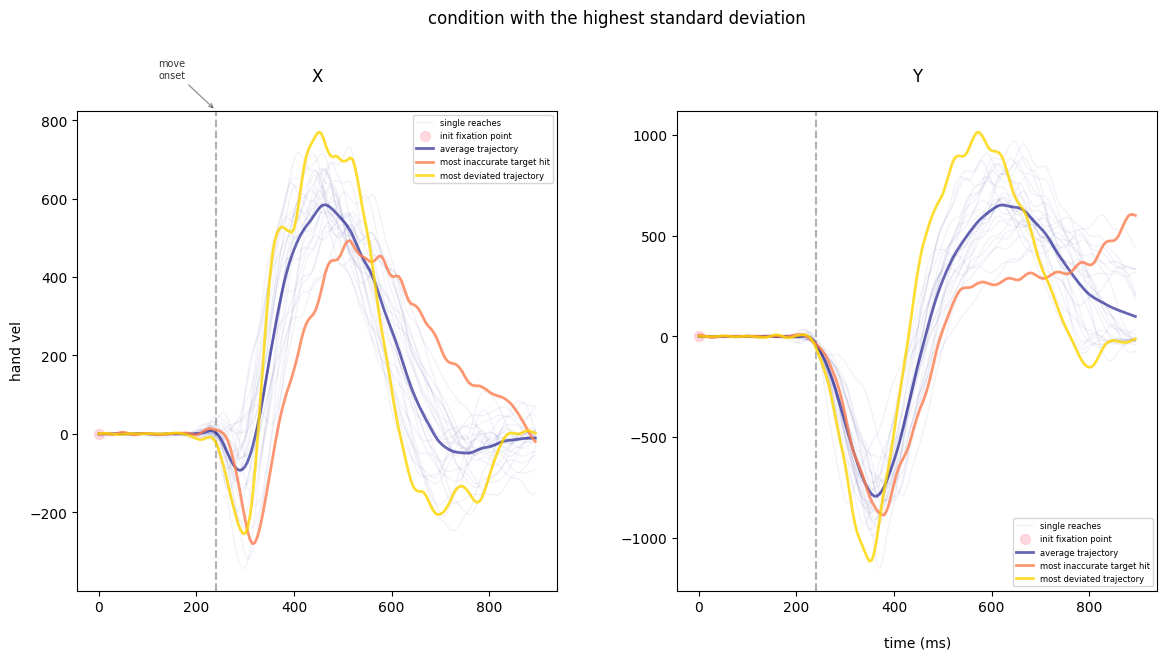

In [307]:
# The condition with the most inaccurate reaches:
inacc_c_id = torch.sort(c_std)[1][-1]

# All reach trajectories in that condition:
trajectories = labels[conds == inacc_c_id]

avg_inacc_traj = trajectories.mean(dim=0)

# The most inaccurate trajectory in that condition:
inacc_traj = trajectories[torch.sort(t_r_norm[conds == inacc_c_id])[1][-1]]

# The most deviated trajectory
dev_traj = trajectories[torch.sort(
    torch.tensor([dis for dis in [torch.norm(trajectories[li] - avg_inacc_traj) for li in range(trajectories.shape[0])]]))[1][-1]]

# Targets shown in the maze for that condition:
#visible_targets =

# Initial fixation point:
init_fix = [0, 0]

# True target for taht condition:
true_target = true_targets[conds == inacc_c_id]

# They are all the same, lets just take one
barriers = [d for d, m in zip(barrier_pos, conds == torch.sort(c_std)[1][-1]) if m]


fig = plt.figure(figsize=(6, 6))
axx = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axy = fig.add_axes([1.1, 0.1, 0.8, 0.8])

cond_idx = inacc_c_id

for traj in trajectories:
    axx.plot(torch.arange(0, traj[:, 0].shape[0], 1)*binsize, traj[:, 0], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    axy.plot(torch.arange(0, traj[:, 1].shape[0], 1)*binsize, traj[:, 1], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')

if mes == 'vel':
    pass
else:
    axx.scatter(n_bins*binsize, cxp[cond_idx, 0], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')
    axy.scatter(n_bins*binsize, cxp[cond_idx, 1], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')

axx.scatter(0, 0, c='pink', marker='o', alpha=0.6, s=50.0, zorder=1, label='init fixation point')
axy.scatter(0, 0, c='pink', marker='o', alpha=0.6, s=50.0, zorder=1, label='init fixation point')
    
axx.plot(torch.arange(0, avg_inacc_traj[:, 0].shape[0], 1)*binsize, avg_inacc_traj[:, 0], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')
axy.plot(torch.arange(0, avg_inacc_traj[:, 1].shape[0], 1)*binsize, avg_inacc_traj[:, 1], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')

axx.plot(torch.arange(0, inacc_traj[:, 0].shape[0], 1)*binsize, inacc_traj[:, 0], linewidth=2.0, color='coral', alpha=0.8, zorder=4, label='most inaccurate target hit')
axy.plot(torch.arange(0, inacc_traj[:, 1].shape[0], 1)*binsize, inacc_traj[:, 1], linewidth=2.0, color='coral', alpha=0.8, zorder=4, label='most inaccurate target hit')

axx.plot(torch.arange(0, dev_traj[:, 0].shape[0], 1)*binsize, dev_traj[:, 0], linewidth=2.0, color='gold', alpha=0.8, zorder=5, label='most deviated trajectory')
axy.plot(torch.arange(0, dev_traj[:, 1].shape[0], 1)*binsize, dev_traj[:, 1], linewidth=2.0, color='gold', alpha=0.8, zorder=5, label='most deviated trajectory')

axx.axvline(x=bins_before*binsize, color='gray', alpha=0.6, linestyle='--')
axy.axvline(x=bins_before*binsize, color='gray', alpha=0.6, linestyle='--')

axx.annotate(f"move\nonset",
            xy=(bins_before*binsize, axx.get_ylim()[1]),
            xytext=(bins_before * binsize - (n_bins * binsize * 0.1), (axx.get_ylim()[1] * 1.1)),
            arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
            fontsize=7, alpha=0.8, ha='center')

# Maze frame (from the experiment)
#ax.set_xlim(-200+20, 200-20)
#ax.set_ylim(-155+20, 155-20)
#axx.set_xlim(plt.xlim()[0] - 100, plt.xlim()[1] + 100)
#axx.set_ylim(plt.ylim()[0] - 100, plt.ylim()[1] + 100)
#axy.set_xlim(plt.xlim()[0] - 100, plt.xlim()[1] + 100)
#axy.set_ylim(plt.ylim()[0] - 100, plt.ylim()[1] + 100)

#plt.axis('off')
axx.set_title('X\n') 
axx.legend(fontsize=6, loc='upper right')
axx.set_ylabel(f'{obj} {mes}', fontsize=10)
axy.set_title('Y\n') 
axy.legend(fontsize=6, loc='lower right')
axy.set_xlabel('\ntime (ms)', fontsize=10)
#fig.suptitle(f'condition with the highest standard deviation\n\n', fontsize=12)
fig.text(1, 0.95, f'condition with the highest standard deviation\n\n\n\n\n\n', ha='center', va='center', fontsize=12)

fig.savefig(f'xy_{obj}_{mes}_most_dispersed_condition.pdf', bbox_inches='tight')
plt.show()

### Empirical average rˆ2

In [402]:
# Trial-averaged reaches of each condition
cxbxv = torch.zeros((n_conds, labels.shape[1], labels.shape[2]))

for ci in range(n_conds):
    mask = conds[:-n_valid_trials] == ci
    cxbxv[ci, :, :] = labels[:-n_valid_trials, :, :][mask, :, :].mean(axis=0)
    c_std[ci] = cxbxv[ci, :, :].std(axis=0).mean(axis=0)
    
# Tensor of trials x bins x 2 where bins x 2 is the trial average reach condition for the condition of each trial
l_c_avg = torch.cat([a.unsqueeze(0) for a in [cxbxv[conds[li]] for li in range(labels.shape[0])]], dim=0)

In [409]:
labels[-n_valid_trials // 2:].reshape(-1, 2).shape

torch.Size([49320, 2])

In [413]:
torch.mean(labels[-n_valid_trials // 2:].reshape(-1, 2))

tensor(11.0738)

In [ ]:
torch.mean(labels[-n_valid_trials // 2:].reshape(-1, 2))

In [404]:
'''
In x and y:
'''
n_valid_trials = 547

# Calculate the total sum of squares (SS_tot)
ss_tot = torch.sum((labels[-n_valid_trials // 2:].reshape(-1, 2) - torch.mean(labels[-n_valid_trials // 2:].reshape(-1, 2))) ** 2)

# Calculate the residual sum of squares (SS_res)
ss_res = torch.sum((labels[-n_valid_trials // 2:].reshape(-1, 2) - l_c_avg[-n_valid_trials // 2:].reshape(-1, 2)) ** 2)

# Calculate R²
emp_avg_r2 = 1 - (ss_res / ss_tot)
emp_avg_r2

tensor(0.8995)

In [406]:
'''
Just for x:
'''
n_valid_trials = 547

# Calculate the total sum of squares (SS_tot)
ss_tot = torch.sum((labels[-n_valid_trials // 2:, :, 0].reshape(-1) - torch.mean(labels[-n_valid_trials // 2:, :, 0].reshape(-1))) ** 2)

# Calculate the residual sum of squares (SS_res)
ss_res = torch.sum((labels[-n_valid_trials // 2:, :, 0].reshape(-1) - l_c_avg[-n_valid_trials // 2:, :, 0].reshape(-1)) ** 2)

# Calculate R²
emp_avg_r2 = 1 - (ss_res / ss_tot)
emp_avg_r2

tensor(0.9212)

In [398]:
'''
Just for y:
'''
n_valid_trials = 547

# Calculate the total sum of squares (SS_tot)
ss_tot = torch.sum((labels[-n_valid_trials // 2:, :, 1].reshape(-1) - torch.mean(labels[-n_valid_trials // 2:, :, 1].reshape(-1))) ** 2)

# Calculate the residual sum of squares (SS_res)
ss_res = torch.sum((labels[-n_valid_trials // 2:, :, 1].reshape(-1) - l_c_avg[-n_valid_trials // 2:, :, 1].reshape(-1)) ** 2)

# Calculate R²
emp_avg_r2 = 1 - (ss_res / ss_tot)
emp_avg_r2

tensor(0.8729)

In [417]:
(0.9212+0.8729)/2

0.89705

### Has XFADS learned the same dynamical system from the same dastaset with different bin size?

In [334]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
    %cd content
    !git clone https://github.com/catniplab/xfads.git
    %cd xfads
    !pip install torch pytorch-lightning scikit-learn matplotlib einops
    !pip install -e .
'''    
else:
    !git clone https://github.com/catniplab/xfads.git
    !pip install pytorch-lightning scikit-learn seaborn hydra-core matplotlib einops nlb-tools dandi
    !pip install -e .
'''

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import seaborn as sns
import os
import gc

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as Fn
import pytorch_lightning as lightning

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, GradientAccumulationScheduler
from pytorch_lightning.strategies import DeepSpeedStrategy
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.plugins.precision import deepspeed

from sklearn.linear_model import Ridge

if is_running_in_colab():
  %cd /content/xfads 

import xfads.utils as utils
import xfads.prob_utils as prob_utils

from xfads import plot_utils

from xfads.ssm_modules.likelihoods import PoissonLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM, LightningMonkeyReaching
from xfads.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

from xfads.ssm_modules.prebuilt_models import create_xfads_poisson_log_link

import warnings
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    # To avoid GPU Memory Fragmentation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [336]:
# Wher to save all the resulting figures
!mkdir output_figs

"""config"""

cfg = {
    # --- graphical model --- #
    'n_latents': 40,
    'n_latents_read': 35,

    'rank_local': 15,
    'rank_backward': 5,

    'n_hidden_dynamics': 128,

    # --- inference network --- #
    'n_samples': 25,
    'n_hidden_local': 256,
    'n_hidden_backward': 128,

    # --- hyperparameters --- #
    'use_cd': False,
    'p_mask_a': 0.0,
    'p_mask_b': 0.0,
    'p_mask_apb': 0.0,
    'p_mask_y_in': 0.0,
    'p_local_dropout': 0.4,
    'p_backward_dropout': 0.0,

    # --- training --- #
    'device': 'cpu',
    'data_device': 'cpu',
 
    'lr': 1e-3,
    'n_epochs': 1000,
    'batch_sz': 32,
    'minibatch_sz': 8,
    'use_minibatching': False,

    # --- misc --- #
    'bin_sz': 5e-3,
    'bin_sz_ms': 5,
    
    'n_bins_enc': 140,

    'seed': 1236,
    'default_dtype': torch.float32,
    
    'shuffle_train': False,
    'shuffle_valid': False,
    'shuffle_test': False,
    
    # --- ray --- #
    'n_ray_samples': 10,
}

class Cfg(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        else:
            raise AttributeError(f"'DictAsAttributes' object has no attribute '{attr}'")

cfg = Cfg(cfg)

lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

mkdir: output_figs: File exists


Seed set to 1236


In [338]:
# obs: observations
y_train_obs = y.type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]
y_valid_obs = y.type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]
y_test_obs = y.type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]

# l: label
l_train = l_train[:, :cfg.n_bins_enc, :]
l_valid = l_train[:, :cfg.n_bins_enc, :]
l_test = l_train[:, :cfg.n_bins_enc, :]

NameError: name 'l_train' is not defined

In [ ]:
def sync_permutation(*tensors):
    permutated = ()
    torch.manual_seed(cfg.seed)
    permutation_indcs = torch.randperm(tensors[0].shape[0])
    print(f"permutation indices: {permutation_indcs}")
    for _, tensor in enumerate(tensors):
        permutated += (tensor[permutation_indcs],)
    lightning.seed_everything(cfg.seed, workers=True)
    
    return permutated

if cfg.shuffle_train:
    y_train_obs, l_train, b_train, tp_train, c_train = sync_permutation(y_train_obs, l_train, b_train)
if cfg.shuffle_valid:
    y_valid_obs, l_valid, b_valid, tp_valid, c_valid = sync_permutation(y_valid_obs, l_valid, b_valid)
if cfg.shuffle_test:
    y_test_obs, l_test, b_test = sync_permutation(y_test_obs, l_test, b_test)
    
y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, l_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, l_valid)     
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, l_test)

# IMPORTANT: the "shuffle" parameter in the DataLoader SHOULD ALWAYS BE SET TO "False", for all regimes, because, we already did the sync shuffeling.
# If you are just interested in the observations and labels, without any specification for the time bins of certain events, then you can use it casually.
train_dataloader = torch.utils.data.DataLoader(
    y_train_dataset, batch_size=cfg.batch_sz, num_workers=4, pin_memory=True, shuffle=False
)
valid_dataloader = torch.utils.data.DataLoader(
    y_val_dataset, batch_size=cfg.batch_sz, num_workers=4, pin_memory=True, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    y_test_dataset, batch_size=cfg.batch_sz, num_workers=4, pin_memory=True, shuffle=False
)

# Data dimensions
n_train_trials, n_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]

# Append data-related attributes to the config Dictionary.
cfg['n_bins'] = n_bins
# Number of time bins used by the model to infere the latents.
#cfg['n_bins_enc'] = train_data['n_bins_enc']
cfg['n_bins_enc'] = 140
# Number of timesteps used by the model to to predict and unroll the latnt trajectories for n_bins - n_bins_bhv timesteps.
#cfg['n_bins_bhv'] = cfg.n_bins // 4
cfg['n_bins_bhv'] = 40

cfg['n_neurons_obs'] = n_neurons_obs
# Number of top most active neurons used by the model to infere the latents.
"""TODO: Let the user specifiy the number of neurons - order and then clip."""
"""TODO: Remove the 'n_bins_bhv' attribute from the data saved by NeuroTask."""
"""TODO: Put clearer destingtion between n_neurons_obs and n_neurons_enc. Maybe just use n_neurons_enc in the rest of the code?."""
cfg['n_neurons_enc'] = n_neurons_obs

cfg = Cfg(cfg)

In [ ]:
"""likelihood pdf"""
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, nn.Linear(cfg.n_latents_read, n_neurons_obs))
readout_fn[-1].bias.data = prob_utils.estimate_poisson_rate_bias(train_dataloader, cfg.bin_sz)
likelihood_pdf = PoissonLikelihood(readout_fn, n_neurons_obs, cfg.bin_sz, device=cfg.device)

"""dynamics module"""
Q_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

"""initial condition"""
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
Q_0_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

"""local/backward encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons_obs, cfg.n_hidden_local, cfg.n_latents,
                                  rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

"""sequence vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

In [ ]:
"""lightning"""
model_ckpt_path = 'ckpts/smoother/acausal/epoch=497_valid_loss=2061.79_r2_valid_enc=0.84_r2_valid_bhv=0.75_valid_bps_enc=0.57.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=cfg.n_bins_enc, n_time_bins_bhv=cfg.n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

In [ ]:
"""inference"""
z_s_train = []
z_f_train = []
z_p_train = []

rates_train_s = []
rates_train_f = []
rates_train_p = []

z_s_valid = []
z_f_valid = []
z_p_valid = []

rates_valid_s = []
rates_valid_f = []
rates_valid_p = []

z_s_test = []
z_f_test = []
z_p_test = []

rates_test_s = []
rates_test_f = []
rates_test_p = []

stats_s_train = []
stats_f_train = []
stats_s_valid = []
stats_f_valid = []
stats_s_test = []
stats_f_test = []

with torch.no_grad():
    m_0 = seq_vae.ssm.nl_filter.initial_c_pdf.m_0
    Q_0 = Fn.softplus(seq_vae.ssm.nl_filter.initial_c_pdf.log_Q_0)
    #m_0 = seq_vae.ssm.dynamics_mod.initial_c_pdf.m_0
    #Q_0 = Fn.softplus(seq_vae.ssm.dynamics_mod.initial_c_pdf.log_Q_0)

    z_ic = m_0 + Q_0.sqrt() * torch.randn([n_test_trials, n_neurons_obs] + [cfg.n_latents], device=cfg.device)
    #z_ic_p = seq_vae.ssm.predict_forward(z_ic[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)

    for batch_idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="train dataloader"):
        loss, z_s, stats_s = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats_f = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_train.append(z_s.to('cpu'))
        z_f_train.append(z_f.to('cpu'))
        z_p_train.append(z_p.to('cpu'))
        
        rates_train_s.append(rates_s)
        rates_train_f.append(rates_f)
        rates_train_p.append(rates_p)
        
        stats_s_train.append(stats_s)
        stats_f_train.append(stats_f)

    for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=len(test_dataloader), desc="valid dataloader"):
        loss, z_s, stats_s = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats_f = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_valid.append(z_s.to('cpu'))
        z_f_valid.append(z_f.to('cpu'))
        z_p_valid.append(z_p.to('cpu'))
        
        rates_valid_s.append(rates_s)
        rates_valid_f.append(rates_f)
        rates_valid_p.append(rates_p)
        
        stats_s_valid.append(stats_s)
        stats_f_valid.append(stats_f)
        
    for batch_idx, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="test dataloader"):
        loss, z_s, stats_s = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats_f = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_test.append(z_s.to('cpu'))
        z_f_test.append(z_f.to('cpu'))
        z_p_test.append(z_p.to('cpu'))
        
        rates_test_s.append(rates_s)
        rates_test_f.append(rates_f)
        rates_test_p.append(rates_p)
        
        stats_s_test.append(stats_s)
        stats_f_test.append(stats_f)

In [ ]:
z_s_train = torch.cat(z_s_train, dim=1).cpu()
z_f_train = torch.cat(z_f_train, dim=1).cpu()
z_p_train = torch.cat(z_p_train, dim=1).cpu()

rates_train_s = torch.cat(rates_train_s, dim=0).cpu()
rates_train_f = torch.cat(rates_train_f, dim=0).cpu()
rates_train_p = torch.cat(rates_train_p, dim=0).cpu()

z_s_valid = torch.cat(z_s_valid, dim=1).cpu()
z_f_valid = torch.cat(z_f_valid, dim=1).cpu()
z_p_valid = torch.cat(z_p_valid, dim=1).cpu()

rates_valid_s = torch.cat(rates_valid_s, dim=0).cpu()
rates_valid_f = torch.cat(rates_valid_f, dim=0).cpu()
rates_valid_p = torch.cat(rates_valid_p, dim=0).cpu()

z_s_test = torch.cat(z_s_test, dim=1).cpu()
z_f_test = torch.cat(z_f_test, dim=1).cpu()
z_p_test = torch.cat(z_p_test, dim=1).cpu()

rates_test_s = torch.cat(rates_test_s, dim=0).cpu()
rates_test_f = torch.cat(rates_test_f, dim=0).cpu()
rates_test_p = torch.cat(rates_test_p, dim=0).cpu()

In [ ]:
'''
spikes per time bin.

To get the number of spikes within each time bin, we should do the poisson sampling from the firing rate as
the number of spikes per time bin.
'''

spikes_train_s = torch.poisson(cfg.bin_sz * rates_train_s).cpu()
spikes_train_f = torch.poisson(cfg.bin_sz * rates_train_f).cpu()
spikes_train_p = torch.poisson(cfg.bin_sz * rates_train_p).cpu()

spikes_test_s = torch.poisson(cfg.bin_sz * rates_test_s).cpu()
spikes_test_f = torch.poisson(cfg.bin_sz * rates_test_f).cpu()
spikes_test_p = torch.poisson(cfg.bin_sz * rates_test_p).cpu()

spikes_valid_s = torch.poisson(cfg.bin_sz * rates_valid_s).cpu()
spikes_valid_f = torch.poisson(cfg.bin_sz * rates_valid_f).cpu()
spikes_valid_p = torch.poisson(cfg.bin_sz * rates_valid_p).cpu()

In [ ]:
vel_train = l_train
vel_valid = l_valid
vel_test = l_test

vel = torch.concat([vel_train, vel_valid, vel_test], dim=0)

In [ ]:
data_spikes = torch.concat([y_train_obs, y_valid_obs, y_test_obs], dim=0)
model_spikes = torch.concat([spikes_train_s, spikes_valid_s, spikes_test_s], dim=0)

data_rates = data_spikes / cfg.bin_sz
model_rates = torch.concat([rates_train_s, rates_valid_s, rates_test_s], dim=0)

In [ ]:
'''
Note that the decoder is trained on the rates generated by XFADS from the latents inferred from the training data.
But tested on the rates generated from the latents inferred from the validation and the testing data.
'''

clf = Ridge(alpha=0.01)
# fit to training data
clf.fit(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
with torch.no_grad():
    r2 = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
    r2_train = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_valid = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_test = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    
    r2_filter = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_k_step = []
    
    # transform train data
    r2_train_s = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_f = clf.score(rates_train_f.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_p = clf.score(rates_train_p.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    vel_hat_train_s = clf.predict(rates_train_s.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_f = clf.predict(rates_train_f.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_p = clf.predict(rates_train_p.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    
    # transform valid data
    r2_valid_s = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_f = clf.score(rates_valid_f.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_p = clf.score(rates_valid_p.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    vel_hat_valid_s = clf.predict(rates_valid_s.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_f = clf.predict(rates_valid_f.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_p = clf.predict(rates_valid_p.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    
    # transform test data
    r2_test_s = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_f = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_p = clf.score(rates_test_p.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    vel_hat_test_s = clf.predict(rates_test_s.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_f = clf.predict(rates_test_f.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_p = clf.predict(rates_test_p.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    
    for k in range(n_bins - cfg.n_bins_bhv):
        z_prd_test = utils.propagate_latent_k_steps(z_f_valid[:, :, k], dynamics_mod.to('cpu'), n_bins + 0 - (k + 1))
        z_prd_test = torch.concat([z_f_valid[:, :, :k], z_prd_test], dim=2)

        # m_prd_test = z_prd_test.mean(dim=0)
        # m_prd_test = torch.concat([m_filter[:, :k], m_prd_test[:, k:]], dim=1)

        rates_prd_test = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_prd_test.to(cfg.device))).mean(dim=0)

        r2_prd = clf.score(rates_prd_test.reshape(-1, n_neurons_obs).cpu(), vel_valid.reshape(-1, 2))
        r2_k_step.append(r2_prd)

        
if torch.cuda.is_available():  
    gc.collect()
    torch.cuda.empty_cache()

In [276]:
vel_to_pos = lambda v: torch.cumsum(torch.tensor(v), dim=1)

pos_train = vel_to_pos(vel_train)
pos_valid = vel_to_pos(vel_valid)
pos_test = vel_to_pos(vel_test)

pos_train_hat_s = vel_to_pos(vel_hat_train_s)
pos_train_hat_f = vel_to_pos(vel_hat_train_f)
pos_train_hat_p = vel_to_pos(vel_hat_train_p)

pos_valid_hat_s = vel_to_pos(vel_hat_valid_s)
pos_valid_hat_f = vel_to_pos(vel_hat_valid_f)
pos_valid_hat_p = vel_to_pos(vel_hat_valid_p)

pos_test_hat_s = vel_to_pos(vel_hat_test_s)
pos_test_hat_f = vel_to_pos(vel_hat_test_f)
pos_test_hat_p = vel_to_pos(vel_hat_test_p)

pos = torch.concat([pos_train, pos_valid, pos_test], dim=0)
pos_hat_s = torch.concat([pos_train_hat_s, pos_valid_hat_s, pos_test_hat_s], dim=0)
pos_hat_f = torch.concat([pos_train_hat_f, pos_valid_hat_f, pos_test_hat_f], dim=0)
pos_hat_p = torch.concat([pos_train_hat_p, pos_valid_hat_p, pos_test_hat_p], dim=0)

reach_angles_rad = torch.atan2(pos[:, -1, 0], pos[:, -1, 1])
reach_angles_deg = torch.rad2deg(reach_angles_rad) + 360 / 2

NameError: name 'vel_train' is not defined

In [277]:
"""plotting"""
n_trials_plot = 125
n_samples_mu_plt = 20

blues = cm.get_cmap("Blues", n_samples_mu_plt)
grays = cm.get_cmap("Greys", n_samples_mu_plt)
yellows = cm.get_cmap("YlOrBr", n_samples_mu_plt)

trial_plt_dx = torch.randperm(n_test_trials)[:n_trials_plot]
reach_angle = torch.atan2(pos_test[:, -1, 0], pos_test[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    plot_utils.plot_reaching(axs[0], pos_test[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_test_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_test_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_test_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_test_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_test_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_test_p:.3f}')
    
    plt.savefig('reach.png')
    plt.show()

NameError: name 'n_test_trials' is not defined

In [279]:
plt.axvline(cfg.n_bins_bhv, linestyle='--')
plt.plot(r2_k_step)
plt.axhline(r2_train, color='green', label='smoothed')
plt.axhline(r2_filter, color='orange', label='filtered')
plt.legend()
plt.savefig('r2')
plt.show()

NameError: name 'cfg' is not defined

In [ ]:
l_c_avg[:-n_valid_trials].reshape(-1, 2)

In [ ]:
l_c_avg.shape

In [ ]:
'''
Note that the decoder is trained on the rates generated by XFADS from the latents inferred from the training data.
But tested on the rates generated from the latents inferred from the validation and the testing data.
'''

clf = Ridge(alpha=0.01)
# fit to training data
clf.fit(rates_train_s.reshape(-1, n_neurons_obs), l_c_avg[:-n_valid_trials].reshape(-1, 2))
    
with torch.no_grad():
    r2 = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
    r2_train = clf.score(rates_train_s.reshape(-1, n_neurons_obs), l_c_avg[:-n_valid_trials].reshape(-1, 2))
    r2_valid = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials:-n_valid_trials // 2].reshape(-1, 2))
    r2_test = clf.score(rates_test_s.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials // 2:].reshape(-1, 2))
    
    r2_filter = clf.score(rates_test_f.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials // 2:].reshape(-1, 2))
    r2_k_step = []
    
    # transform train data
    r2_train_s = clf.score(rates_train_s.reshape(-1, n_neurons_obs), l_c_avg[:-n_valid_trials].reshape(-1, 2))
    r2_train_f = clf.score(rates_train_f.reshape(-1, n_neurons_obs), l_c_avg[:-n_valid_trials].reshape(-1, 2))
    r2_train_p = clf.score(rates_train_p.reshape(-1, n_neurons_obs), l_c_avg[:-n_valid_trials].reshape(-1, 2))
    vel_hat_train_s = clf.predict(rates_train_s.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_f = clf.predict(rates_train_f.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_p = clf.predict(rates_train_p.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    
    # transform valid data
    r2_valid_s = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials:-n_valid_trials // 2].reshape(-1, 2))
    r2_valid_f = clf.score(rates_valid_f.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials:-n_valid_trials // 2].reshape(-1, 2))
    r2_valid_p = clf.score(rates_valid_p.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials:-n_valid_trials // 2].reshape(-1, 2))
    vel_hat_valid_s = clf.predict(rates_valid_s.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_f = clf.predict(rates_valid_f.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_p = clf.predict(rates_valid_p.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    
    # transform test data
    r2_test_s = clf.score(rates_test_s.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials // 2:].reshape(-1, 2))
    r2_test_f = clf.score(rates_test_f.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials // 2:].reshape(-1, 2))
    r2_test_p = clf.score(rates_test_p.reshape(-1, n_neurons_obs), l_c_avg[-n_valid_trials // 2:].reshape(-1, 2))
    vel_hat_test_s = clf.predict(rates_test_s.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_f = clf.predict(rates_test_f.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_p = clf.predict(rates_test_p.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    
    for k in range(n_bins - cfg.n_bins_bhv):
        z_prd_test = utils.propagate_latent_k_steps(z_f_valid[:, :, k], dynamics_mod.to('cpu'), n_bins + 0 - (k + 1))
        z_prd_test = torch.concat([z_f_valid[:, :, :k], z_prd_test], dim=2)

        # m_prd_test = z_prd_test.mean(dim=0)
        # m_prd_test = torch.concat([m_filter[:, :k], m_prd_test[:, k:]], dim=1)

        rates_prd_test = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_prd_test.to(cfg.device))).mean(dim=0)

        r2_prd = clf.score(rates_prd_test.reshape(-1, n_neurons_obs).cpu(), l_c_avg[-n_valid_trials // 2:].reshape(-1, 2))
        r2_k_step.append(r2_prd)

        
if torch.cuda.is_available():  
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
vel_to_pos = lambda v: torch.cumsum(torch.tensor(v), dim=1)

pos_train = vel_to_pos(vel_train)
pos_valid = vel_to_pos(vel_valid)
pos_test = vel_to_pos(vel_test)

pos_train_hat_s = vel_to_pos(vel_hat_train_s)
pos_train_hat_f = vel_to_pos(vel_hat_train_f)
pos_train_hat_p = vel_to_pos(vel_hat_train_p)

pos_valid_hat_s = vel_to_pos(vel_hat_valid_s)
pos_valid_hat_f = vel_to_pos(vel_hat_valid_f)
pos_valid_hat_p = vel_to_pos(vel_hat_valid_p)

pos_test_hat_s = vel_to_pos(vel_hat_test_s)
pos_test_hat_f = vel_to_pos(vel_hat_test_f)
pos_test_hat_p = vel_to_pos(vel_hat_test_p)

pos = torch.concat([pos_train, pos_valid, pos_test], dim=0)
pos_hat_s = torch.concat([pos_train_hat_s, pos_valid_hat_s, pos_test_hat_s], dim=0)
pos_hat_f = torch.concat([pos_train_hat_f, pos_valid_hat_f, pos_test_hat_f], dim=0)
pos_hat_p = torch.concat([pos_train_hat_p, pos_valid_hat_p, pos_test_hat_p], dim=0)

reach_angles_rad = torch.atan2(pos[:, -1, 0], pos[:, -1, 1])
reach_angles_deg = torch.rad2deg(reach_angles_rad) + 360 / 2

In [ ]:
"""plotting"""
n_trials_plot = 125
n_samples_mu_plt = 20

blues = cm.get_cmap("Blues", n_samples_mu_plt)
grays = cm.get_cmap("Greys", n_samples_mu_plt)
yellows = cm.get_cmap("YlOrBr", n_samples_mu_plt)

trial_plt_dx = torch.randperm(n_test_trials)[:n_trials_plot]
reach_angle = torch.atan2(pos_test[:, -1, 0], pos_test[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    plot_utils.plot_reaching(axs[0], pos_test[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_test_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_test_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_test_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_test_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_test_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_test_p:.3f}')
    
    plt.savefig('reach2.png')
    plt.show()

In [ ]:
plt.axvline(cfg.n_bins_bhv, linestyle='--')
plt.plot(r2_k_step)
plt.axhline(r2_train, color='green', label='smoothed')
plt.axhline(r2_filter, color='orange', label='filtered')
plt.legend()
plt.savefig('r22.png')
plt.show()